# 2. Topic modelling

## Setup

In [1]:
%run __init__.py

In [2]:
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/home/alejandro/.envs/edma/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
RANDOM_SEED=42

## Loading the dataframe

In [4]:
GIT_FILE_PATH = os.path.join(NOTEBOOK_1_RESULTS_DIR, 'git_dataframe.pkl')

git_df = pd.read_pickle(GIT_FILE_PATH)

## Preprocessing text

In [5]:
git_repositories = git_df['full_text_cleaned'].values

In [6]:
MAX_CHAR_LENGTH = 100000

git_repositories = [r[:MAX_CHAR_LENGTH] for r in git_repositories]

In [7]:
import en_core_sci_lg

from herc_common.text import TextPreprocessor


custom_stop_words = {"merge", "branch", "master", "refs", "svn",
                     "branch", "pull", "request", "fix", "ref",
                     "error", "add", "file", "bug", "class", "return",
                     "string"}

git_preprocessor = TextPreprocessor(en_core_sci_lg, custom_stop_words)
preprocessed_texts = git_preprocessor.fit_transform(git_repositories)

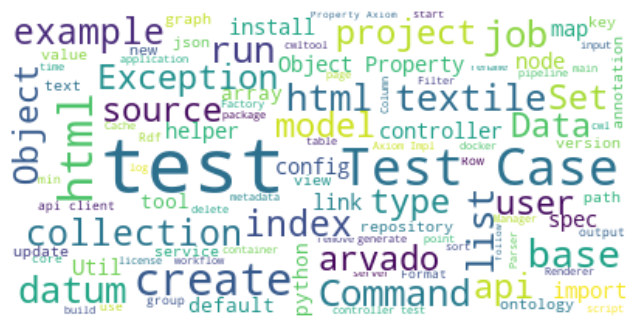

In [8]:
from herc_common.text import plot_word_cloud

complete_text = ' '.join([' '.join(token) for token in preprocessed_texts])

plot_word_cloud(complete_text)

## LDA

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc


tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
dtm_tf = tf_vectorizer.fit_transform(preprocessed_texts)

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

from herc_common.topic_modeling import base_scoring_function, compute_model_results


lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tf_vectorizer,
                                        texts=preprocessed_texts, model=clf, X=X)


lda_results = compute_model_results(LatentDirichletAllocation, dtm_tf,
                                    lda_scoring_func, seed=RANDOM_SEED,
                                    min_topics=15, max_topics=70, max_iter=100)
lda_results

/home/alejandro/.envs/edma/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


{LatentDirichletAllocation(max_iter=100, n_components=15, random_state=42): -6.159195131258154,
 LatentDirichletAllocation(max_iter=100, n_components=16, random_state=42): -3.5741380084063428,
 LatentDirichletAllocation(max_iter=100, n_components=17, random_state=42): -4.121721937209441,
 LatentDirichletAllocation(max_iter=100, n_components=18, random_state=42): -4.226862447930409,
 LatentDirichletAllocation(max_iter=100, n_components=19, random_state=42): -4.551530526507162,
 LatentDirichletAllocation(max_iter=100, n_components=20, random_state=42): -4.571295810326675,
 LatentDirichletAllocation(max_iter=100, n_components=21, random_state=42): -3.1258476279159337,
 LatentDirichletAllocation(max_iter=100, n_components=22, random_state=42): -5.5685060777748285,
 LatentDirichletAllocation(max_iter=100, n_components=23, random_state=42): -5.230311429400243,
 LatentDirichletAllocation(max_iter=100, n_components=24, random_state=42): -5.304521472471414,
 LatentDirichletAllocation(max_iter=1

In [11]:
from herc_common.topic_modeling import get_best_model, print_results_info

print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

Best model parameters: {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 100, 'mean_change_tol': 0.001, 'n_components': 21, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
Topic coherence: -3.1258476279159337


In [12]:
from herc_common.topic_modeling import print_top_words

tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 10)

Topic #0: music model weight generate run sequence datum Music new library
Topic #1: Test Connection Exception Handler Statement Mysql Data Category Regression Category Handler
Topic #2: feature classifier model checkpoint xgb music curve xgb classifier vgg Music
Topic #3: unimath Disp Bicat Functor Functors Category Categories Strict Monads Pseudo
Topic #4: prov pass Test pass prov property prov property Prov influence license issue
Topic #5: sentence table npuserstudy npuserstudy npuserstudy AIDA uri AIDA sentence spotlight aida example
Topic #6: html bill spec annotation create controller page vote protein committee
Topic #7: graph main odgi sort path node build dynamic example gfa
Topic #8: jetty Kefed system Data small tab powerloom edit Template link
Topic #9: aspnetcoreapp bootstrap min jquery css match virtuoso cshtml aspnetcoreapp csproj csproj
Topic #10: library pogo mmtf import include pogoentry list cmake code test
Topic #11: tool job test run cwltool install workflow packa

In [13]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
16      79.058716  -28.126804       1        1  23.188452
15     150.816483   85.582191       2        1  18.808133
19       3.409561  164.749954       3        1  15.359400
14       8.463515 -147.953537       4        1   6.846358
11      24.501841  -68.729546       5        1   6.410000
17     -47.038795  -84.400673       6        1   5.004227
6       79.187416  130.467224       7        1   4.546483
1      -27.836060  -20.039255       8        1   4.107669
3      -49.480225   49.525143       9        1   2.351147
8       23.319456   16.173618      10        1   2.001863
18     144.186020  -76.104927      11        1   1.902508
12     -68.028908  126.588631      12        1   1.595811
20    -126.578110   72.035843      13        1   1.561460
10     -93.836601   -9.511911      14        1   1.511448
4      -75.701607 -154.276047      15        1   1.308948
7     -127.823074  -82.236237      16        1   1.186518
2       11.143582   86.173927      17        1   0.703295
0       81.912384   49.446846      18        1   0.696798
9     -168.572723   -2.605909      19        1   0.482576
5       82.006874 -123.164391      20        1   0.423882
13     151.189285    3.468220      21        1   0.003024, topic_info=                  Term        Freq       Total Category  logprob  loglift
20502             html  368.000000  368.000000  Default  30.0000  30.0000
9524              Test  464.000000  464.000000  Default  29.0000  29.0000
32956             test  830.000000  830.000000  Default  28.0000  28.0000
13312             case  211.000000  211.000000  Default  27.0000  27.0000
535              Axiom  168.000000  168.000000  Default  26.0000  26.0000
...                ...         ...         ...      ...      ...      ...
12129         auth api    0.000065    1.410172  Topic21 -10.5007   0.4253
12127     augment list    0.000065    1.241011  Topic21 -10.5007   0.5531
12120  audio retrieval    0.000065    0.980769  Topic21 -10.5007   0.7884
12126          augment    0.000065    1.241011  Topic21 -10.5007   0.5531
12125        aug codon    0.000065    5.113775  Topic21 -10.5007  -0.8629

[1460 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
2         20  0.875612            AIDA
61         9  0.978113         Abelian
167        9  0.978113          Ahrens
185        9  0.978113        Algebras
225        4  0.916770        Analysis
...      ...       ...             ...
36139     17  0.513353             xgb
36141     17  0.586106  xgb classifier
36248     16  0.835558           yeast
36259      5  0.948677           yield
36336     13  0.574454            éste

[2230 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 16, 20, 15, 12, 18, 7, 2, 4, 9, 19, 13, 21, 11, 5, 8, 3, 1, 10, 6, 14])

# LSA

In [14]:
from sklearn.decomposition import TruncatedSVD

lsa_scoring_func = lda_scoring_func

lsa_results = compute_model_results(TruncatedSVD, dtm_tf, lsa_scoring_func, 
                                    seed=RANDOM_SEED, min_topics=5,
                                    max_topics=50)
lsa_results

{TruncatedSVD(n_components=5, random_state=42): -2.2158729085417956,
 TruncatedSVD(n_components=6, random_state=42): -2.3835237105097464,
 TruncatedSVD(n_components=7, random_state=42): -2.4137097626779744,
 TruncatedSVD(n_components=8, random_state=42): -3.4372180182775787,
 TruncatedSVD(n_components=9, random_state=42): -3.136308052227185,
 TruncatedSVD(n_components=10, random_state=42): -3.6746046670146213,
 TruncatedSVD(n_components=11, random_state=42): -3.392683993383549,
 TruncatedSVD(n_components=12, random_state=42): -3.5775477460367675,
 TruncatedSVD(n_components=13, random_state=42): -3.5587928517316865,
 TruncatedSVD(n_components=14, random_state=42): -3.632623704851782,
 TruncatedSVD(n_components=15, random_state=42): -3.488979503938329,
 TruncatedSVD(n_components=16, random_state=42): -3.3077160097771188,
 TruncatedSVD(n_components=17, random_state=42): -3.148751255418022,
 TruncatedSVD(n_components=18, random_state=42): -3.3692297969279834,
 TruncatedSVD(n_components=19,

## NMF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
dtm_tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)

In [16]:
from sklearn.decomposition import NMF

nmf_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tfidf_vectorizer,
                                                        texts=preprocessed_texts, model=clf, X=X)

nmf_results = compute_model_results(NMF, dtm_tfidf, nmf_scoring_func, 
                                    seed=RANDOM_SEED, min_topics=5,
                                    max_topics=60, max_iter=700)
nmf_results

/home/alejandro/.envs/edma/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 700 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


{NMF(max_iter=700, n_components=5, random_state=42): -5.201919169188398,
 NMF(max_iter=700, n_components=6, random_state=42): -4.773052223213151,
 NMF(max_iter=700, n_components=7, random_state=42): -5.485199942460794,
 NMF(max_iter=700, n_components=8, random_state=42): -5.921935089050929,
 NMF(max_iter=700, n_components=9, random_state=42): -6.646635978887484,
 NMF(max_iter=700, n_components=10, random_state=42): -6.527104091287359,
 NMF(max_iter=700, n_components=11, random_state=42): -7.252691516167675,
 NMF(max_iter=700, n_components=12, random_state=42): -7.419308307391663,
 NMF(max_iter=700, n_components=13, random_state=42): -6.097636850386683,
 NMF(max_iter=700, n_components=14, random_state=42): -6.620440112970752,
 NMF(max_iter=700, n_components=15, random_state=42): -5.955376451152129,
 NMF(max_iter=700, n_components=16, random_state=42): -6.500858934151015,
 NMF(max_iter=700, n_components=17, random_state=42): -7.097658222136418,
 NMF(max_iter=700, n_components=18, random_

In [17]:
print_results_info(nmf_results)
best_nmf_model = get_best_model(nmf_results)

Best model parameters: {'alpha': 0.0, 'beta_loss': 'frobenius', 'init': None, 'l1_ratio': 0.0, 'max_iter': 700, 'n_components': 51, 'random_state': 42, 'shuffle': False, 'solver': 'cd', 'tol': 0.0001, 'verbose': 0}
Topic coherence: -0.6135877654331021


In [18]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(best_nmf_model, tfidf_feature_names, 10)

Topic #0: base Command array object test Index create Operation core base base
Topic #1: lirical Command Lirical Test ratio likelihood ratio likelihood phenopacket Phenopacket hpo
Topic #2: Test test Property spec Elda Utils Renderer Query Player apispec
Topic #3: Axiom Test Property case Impl test case Object Case Test Case Test case
Topic #4: music weight model generate Music epoch kera generate music tune quality
Topic #5: prov pass pass prov prov property Prov influence property Test toolbox Round Trip
Topic #6: concept tbox subsumption abox format expansion check axiom consistency want check
Topic #7: html bill spec vote committee controller document create page state
Topic #8: sentence npuserstudy table AIDA npuserstudy npuserstudy aida AIDA sentence spotlight uri Kuhn
Topic #9: codon codon find transcript position initiation codon initiation reading frame wild reading variation
Topic #10: html textile html textile test job collection container controller pipeline arvados
Topic #